# MNIST Multidígito - Baseado na SSD

## Importando os módulos

In [1]:
#!pip install matplotlib torch torchvision shapely[vectorized]

In [2]:
#!wget -q https://raw.githubusercontent.com/fabiocapsouza/ia376f/master/lib/pytorch_trainer_v2_mod.py -Plib/

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import os
import math
import warnings
from collections import OrderedDict

import cv2
import numpy as np
from shapely import geometry

import matplotlib.pyplot as plt
from matplotlib import patches

import torch
import torch.nn as nn
from torch.utils import data
from torch.optim import lr_scheduler
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

# our library
from lib import pytorch_trainer_v2_mod as ptt

In [3]:
# verifica se a GPU esta disponivel
use_gpu = torch.cuda.is_available()
print("Usando GPU:", use_gpu)
print('CPU Cores:', os.cpu_count())
print('Versão OpenCV:', cv2.__version__)

Usando GPU: True
CPU Cores: 4
Versão OpenCV: 3.4.2


## Carregando MNIST dataset

In [4]:
!mkdir data/MNIST

mkdir: cannot create directory ‘data/MNIST’: File exists


In [5]:
dataset_dir = 'data/MNIST/'

# Transformara os dados em tensores no intervalo [0.0, 1.0] (Os dados serão normalizados)
data_transform = transforms.ToTensor()
# data_transform = None

# carrega o conjunto de treinamento e de teste
datasets_mnist = dict(train=MNIST(dataset_dir, train=True,  transform=data_transform, download=True),
                val  =MNIST(dataset_dir, train=False, transform=data_transform, download=True))

print('Amostras para treinamento:', len(datasets_mnist['train']))
print('Amostras para validação:', len(datasets_mnist['val']))
print(type(datasets_mnist['train'].train_data))
print(datasets_mnist['train'].train_data.size())
print(datasets_mnist['train'].train_data.min(), datasets_mnist['train'].train_data.max())

Amostras para treinamento: 60000
Amostras para validação: 10000
<class 'torch.Tensor'>
torch.Size([60000, 28, 28])
tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)


# Definição do dataset com múltiplos dígitos

## Testes iniciais

In [16]:
def make_digit_box(h, w, H, W):
    x = np.random.randint(0, W-1-w)
    y = np.random.randint(0, H-1-h)
    digit_box = geometry.box(x, y, x+w, y+h)
    return x, y, digit_box


# Função para criar uma imagem de teste, colocando várias amostras
def make_sample(dataset, image_size, min_digits=5, max_digits=12, seed=None):
    """Creates an image with many digits from MNIST, without overlap.
    Parameters:
    -----------
    dataset: an instance of MNIST dataset.
    image_size: the output image size. Should be an int of tuple of ints.
    seed (int, optional): constrols the random seed used to generate the images.
        Used for debugging."""
    if isinstance(image_size, int):
        M = (image_size, image_size)
    elif isinstance(image_size, (tuple, list)):
        M = image_size
    else:
        raise TypeError("`image_size` should be an int of tuple of ints.")
    H, W = M
    
    Hy, Wy = output_size = (H//4, W//4)
    
    if seed is not None:
        np.random.seed(seed)
    N = np.random.randint(min_digits, max_digits)    # Number of digits
    char_index = np.random.choice(len(dataset), N, replace=False)

    # Empty image and outputs
    boxes = []
    boxes_geo = []
    image = np.zeros(M, np.uint8)
    
    for k, ix in enumerate(char_index):
        img, lab = dataset[ix]
        img, lab = img.numpy(), lab.numpy()
        img = img.reshape(28, 28)
        lab = int(lab)
        
        # Samples a resizing factor and a random position for the digit
        resizing_factor = 1. if np.random.uniform(0, 1) <= 0.6 else 2.
        h = int(round(img.shape[0] * resizing_factor))
        w = int(round(img.shape[1] * resizing_factor))
        x, y, digit_box = make_digit_box(h, w, H, W)
        
        if boxes:
            retries = 0
            skip = False
            # If the digit box intersects with a previous digit, resample
            while any(digit_box.intersects(box) for box in boxes_geo):
                if retries > 10:
                    skip = True
                    break
                x, y, digit_box = make_digit_box(h, w, H, W)
                retries += 1
            if skip:
                continue
        
        boxes_geo.append(digit_box)
        boxes.append({
            'coords': np.array([x, y, w, h], dtype=np.float) / H,  # This assumes square image size
            'label': lab,
        })
        
        img = cv2.resize(img, (0, 0), fx=resizing_factor, fy=resizing_factor,
                         interpolation=cv2.INTER_AREA if resizing_factor < 1 else cv2.INTER_LINEAR)
        img = (img * 255).clip(0, 255).astype(np.uint8)
        image[y:y+h, x:x+w] = img
        
    return image, boxes

In [6]:
def box2cell(box, grid_sz=10):
    """Receives a box (x0, y0, H, W) and returns the output cell (cx, cy)
    the box center falls in and the center offsets tx and ty, in range [0,1].
    
    Parameters:
    -----------
    box: iterable with [x0, y0, h, w], where (x0,y0) is the top-left vertice
        and h, w are the height and width of the box.
    downsample (int): downsample factor of the cells' layer.
    """
    
    cell_sz = 1./grid_sz
    x, y, w, h = box
    
    cx = int((x + w/2) // cell_sz)
    cy = int((y + h/2) // cell_sz)
    
    # tx e ty no range [-1, 1]
    tx = -1. + 2 * (((x + w/2) % cell_sz) / cell_sz)
    ty = -1. + 2 * (((y + h/2) % cell_sz) / cell_sz)
    
    return cx, cy, tx, ty

In [19]:
make_sample(datasets_mnist['train'], (160, 160), seed=1337)

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 [{'coords': array([0.625, 0.6  , 0.175, 0.175]), 'label': 0},
  {'coords': array([0.05   , 0.06875, 0.175  , 0.175  ]), 'label': 0},
  {'coords': array([0.25625, 0.15   , 0.35   , 0.35   ]), 'label': 8},
  {'coords': array([0.03125, 0.61875, 0.35   , 0.35   ]), 'label': 4},
  {'coords': array([0.6875 , 0.04375, 0.175  , 0.175  ]), 'label': 3},
  {'coords': array([0.625, 0.3  , 0.175, 0.175]), 'label': 4},
  {'coords': array([0.4    , 0.75625, 0.175  , 0.175  ]), 'label': 0},
  {'coords': array([0.3875, 0.5125, 0.175 , 0.175 ]), 'label': 0}])

In [20]:
def plot_sample(sample, grid_szs=[10, 5]):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

    img, boxes = sample
    H, W = img.shape
    img = np.dstack((img, img, img))
    
    # h, w = H/grid_sz, W/grid_sz
    # grid[anchor_size] = np.zeros((h, w), dtype=np.uint8)

    for box in boxes:
        coords = box['coords']
        x, bw = coords[0::2] * W 
        y, bh = coords[1::2] * H
#         cx, cy, tx, ty = box2cell(coords, grid_sz)

        Cx = int(x+bw/2)
        Cy = int(y+bh/2)
        # Indicador vermelho de onde está o centro
        img[Cy-2:Cy+2, Cx-2:Cx+2, :] = np.array([255, 0, 0])

        #grid[anchor_size][cy, cx] = 1
            
        
    ax = axs#[0]
    cax = ax.imshow(img, cmap='gray')
    ax.set_title('Imagem de entrada')
    fig.colorbar(cax, ax=ax)
    ax.set_xticks(np.arange(0, W, 16), minor=False)
    ax.set_yticks(np.arange(0, H, 16), minor=False)
    ax.grid(True, which='major', linestyle='-')
    ax.grid(True, which='minor', linestyle=':')
    
#     for j, anchor_size in enumerate(grid.keys(), start=1):
#         ax = axs[j]
#         cax = ax.imshow(grid[anchor_size], cmap='gray')
#         h, w = (10, 10) if anchor_size == 28 else (5, 5)
#         ax.set_title(f'Células responsáveis no feat map ({h}, {w})')
#         fig.colorbar(cax, ax=ax)
        
#         ax.set_xticks(np.arange(0, w))
#         ax.set_yticks(np.arange(0, h))
#         ax.grid(True)

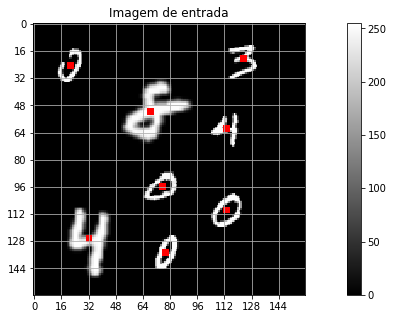

In [21]:
plot_sample(make_sample(datasets_mnist['train'], (160, 160), seed=1337))

In [22]:
class MultiDigitDataset(torch.utils.data.Dataset):
    
    def __init__(self, dataset, image_size=(160, 160), transform=None, length=None, random=False):
        self.dataset = dataset
        self.image_size = image_size
        self.length = length or len(dataset)
        self.random = random
        
        self.transform = transform
        
    def set_length(self, length):
        """Sets the length of the dataset. Useful to limit the dataset
        to a small number of samples."""
        self.length = length
        
    def __len__(self):
        return self.length
        
    def __getitem__(self, ix):
        seed = ix if not self.random else None
        img, boxes = make_sample(self.dataset, self.image_size, seed=seed)
        
        img = img[..., np.newaxis]
        
        if self.transform:
            img = self.transform(img)
        return img, boxes

Visualizando shapes, dtypes, valores mínimo e máximo

In [23]:
ds = {
    'train': MultiDigitDataset(datasets_mnist['train'], length=128, random=False),
    'val': MultiDigitDataset(datasets_mnist['val'], length=128, random=False),
}

In [24]:
x, y = ds['train'][0]

print('x:', x.shape, x.dtype, x.min(), x.max())
print(y)

x: (160, 160, 1) uint8 0 255
[{'coords': array([0.45625, 0.05   , 0.35   , 0.35   ]), 'label': 3}, {'coords': array([0.50625, 0.5625 , 0.35   , 0.35   ]), 'label': 6}, {'coords': array([0.03125, 0.18125, 0.35   , 0.35   ]), 'label': 4}, {'coords': array([0.11875, 0.6    , 0.175  , 0.175  ]), 'label': 0}]


## Definição do modelo totalmente convolucional

In [68]:
def make_anchors(anc_grid, k=1):
    anc_offset = 1/(anc_grid*2)
    anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
    anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)

    anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
    anc_sizes = np.array([[1/anc_grid, 1/anc_grid] for i in range(anc_grid*anc_grid)])
    anchors = torch.tensor(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()
    return anchors

In [69]:
make_anchors(10)

tensor([[0.0500, 0.0500, 0.1000, 0.1000],
        [0.0500, 0.1500, 0.1000, 0.1000],
        [0.0500, 0.2500, 0.1000, 0.1000],
        [0.0500, 0.3500, 0.1000, 0.1000],
        [0.0500, 0.4500, 0.1000, 0.1000],
        [0.0500, 0.5500, 0.1000, 0.1000],
        [0.0500, 0.6500, 0.1000, 0.1000],
        [0.0500, 0.7500, 0.1000, 0.1000],
        [0.0500, 0.8500, 0.1000, 0.1000],
        [0.0500, 0.9500, 0.1000, 0.1000],
        [0.1500, 0.0500, 0.1000, 0.1000],
        [0.1500, 0.1500, 0.1000, 0.1000],
        [0.1500, 0.2500, 0.1000, 0.1000],
        [0.1500, 0.3500, 0.1000, 0.1000],
        [0.1500, 0.4500, 0.1000, 0.1000],
        [0.1500, 0.5500, 0.1000, 0.1000],
        [0.1500, 0.6500, 0.1000, 0.1000],
        [0.1500, 0.7500, 0.1000, 0.1000],
        [0.1500, 0.8500, 0.1000, 0.1000],
        [0.1500, 0.9500, 0.1000, 0.1000],
        [0.2500, 0.0500, 0.1000, 0.1000],
        [0.2500, 0.1500, 0.1000, 0.1000],
        [0.2500, 0.2500, 0.1000, 0.1000],
        [0.2500, 0.3500, 0.1000, 0

In [70]:
make_anchors(5)

tensor([[0.1000, 0.1000, 0.2000, 0.2000],
        [0.1000, 0.3000, 0.2000, 0.2000],
        [0.1000, 0.5000, 0.2000, 0.2000],
        [0.1000, 0.7000, 0.2000, 0.2000],
        [0.1000, 0.9000, 0.2000, 0.2000],
        [0.3000, 0.1000, 0.2000, 0.2000],
        [0.3000, 0.3000, 0.2000, 0.2000],
        [0.3000, 0.5000, 0.2000, 0.2000],
        [0.3000, 0.7000, 0.2000, 0.2000],
        [0.3000, 0.9000, 0.2000, 0.2000],
        [0.5000, 0.1000, 0.2000, 0.2000],
        [0.5000, 0.3000, 0.2000, 0.2000],
        [0.5000, 0.5000, 0.2000, 0.2000],
        [0.5000, 0.7000, 0.2000, 0.2000],
        [0.5000, 0.9000, 0.2000, 0.2000],
        [0.7000, 0.1000, 0.2000, 0.2000],
        [0.7000, 0.3000, 0.2000, 0.2000],
        [0.7000, 0.5000, 0.2000, 0.2000],
        [0.7000, 0.7000, 0.2000, 0.2000],
        [0.7000, 0.9000, 0.2000, 0.2000],
        [0.9000, 0.1000, 0.2000, 0.2000],
        [0.9000, 0.3000, 0.2000, 0.2000],
        [0.9000, 0.5000, 0.2000, 0.2000],
        [0.9000, 0.7000, 0.2000, 0

In [76]:
def hw2corners(centers, hw):
    return torch.cat([centers - hw/2, centers + hw/2], dim=1)

In [77]:
anc = make_anchors(5)
hw2corners(anc[:, :2], anc[:, 2:])

tensor([[0.0000, 0.0000, 0.2000, 0.2000],
        [0.0000, 0.2000, 0.2000, 0.4000],
        [0.0000, 0.4000, 0.2000, 0.6000],
        [0.0000, 0.6000, 0.2000, 0.8000],
        [0.0000, 0.8000, 0.2000, 1.0000],
        [0.2000, 0.0000, 0.4000, 0.2000],
        [0.2000, 0.2000, 0.4000, 0.4000],
        [0.2000, 0.4000, 0.4000, 0.6000],
        [0.2000, 0.6000, 0.4000, 0.8000],
        [0.2000, 0.8000, 0.4000, 1.0000],
        [0.4000, 0.0000, 0.6000, 0.2000],
        [0.4000, 0.2000, 0.6000, 0.4000],
        [0.4000, 0.4000, 0.6000, 0.6000],
        [0.4000, 0.6000, 0.6000, 0.8000],
        [0.4000, 0.8000, 0.6000, 1.0000],
        [0.6000, 0.0000, 0.8000, 0.2000],
        [0.6000, 0.2000, 0.8000, 0.4000],
        [0.6000, 0.4000, 0.8000, 0.6000],
        [0.6000, 0.6000, 0.8000, 0.8000],
        [0.6000, 0.8000, 0.8000, 1.0000],
        [0.8000, 0.0000, 1.0000, 0.2000],
        [0.8000, 0.2000, 1.0000, 0.4000],
        [0.8000, 0.4000, 1.0000, 0.6000],
        [0.8000, 0.6000, 1.0000, 0

In [82]:
torch.tensor(np.array([1/4]), requires_grad=False).unsqueeze(1)

tensor([[0.2500]], dtype=torch.float64)

In [64]:
k = 1
c = 11
a = torch.zeros((1, c*k, 2, 2))
a[0, :, 0, 0] = torch.arange(c*k)
a[0, :, 1, 0] = c*k-torch.arange(c*k)
a

tensor([[[[ 0.,  0.],
          [11.,  0.]],

         [[ 1.,  0.],
          [10.,  0.]],

         [[ 2.,  0.],
          [ 9.,  0.]],

         [[ 3.,  0.],
          [ 8.,  0.]],

         [[ 4.,  0.],
          [ 7.,  0.]],

         [[ 5.,  0.],
          [ 6.,  0.]],

         [[ 6.,  0.],
          [ 5.,  0.]],

         [[ 7.,  0.],
          [ 4.,  0.]],

         [[ 8.,  0.],
          [ 3.,  0.]],

         [[ 9.,  0.],
          [ 2.,  0.]],

         [[10.,  0.],
          [ 1.,  0.]]]])

In [65]:
nb, nf, gx, gy = a.size()
a = a.permute(0, 2, 3, 1).contiguous()
a

tensor([[[[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],

         [[11., 10.,  9.,  8.,  7.,  6.,  5.,  4.,  3.,  2.,  1.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]]])

In [66]:
a.view(nb, -1, nf//k)

tensor([[[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [11., 10.,  9.,  8.,  7.,  6.,  5.,  4.,  3.,  2.,  1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]])

In [75]:
def flatten_conv(x, k):
    """Converts a feature map to shape (batch_size, box_features, N_boxes).
    k is the number of anchor boxes per feature map cell.
    e.g. if used for bbox offsets, output would be (batch_size, 4, N_boxes).
    For class scores, output would be (batch_size, num_classes, N_boxes). """
    nb, nf, gx, gy = x.size()
    x = x.permute(0, 2, 3, 1).contiguous()
    return x.view(nb, -1, nf//k)


class OutConv(nn.Module):
    
    def __init__(self, in_channels, num_classes, k=1):
        super().__init__()
        self.k = k
        self.out_conv1 = nn.Conv2d(in_channels=in_channels, out_channels=4*k, kernel_size=1, padding=0)
        self.out_conv2 = nn.Conv2d(in_channels=in_channels, out_channels=(num_classes+1)*k, kernel_size=1,
                                   padding=0)
        
    def forward(self, x):
        # Returns a list with bboxes coordinates offsets and predicted class scores
        return [flatten_conv(self.out_conv1(x), k=self.k),
                flatten_conv(self.out_conv2(x), k=self.k)]


class MyModel(nn.Module):
    
    def make_conv_block(self, in_channels, out_channels, kernel_size=3, padding=1):
        layers = [
            nn.Conv2d(in_channels=in_channels,
                      out_channels=out_channels,
                      kernel_size=kernel_size,
                      padding=padding,
                      bias=False,
                     ),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
        ]

        return nn.Sequential(*layers)


    def __init__(self, num_classes, k):
        super(MyModel, self).__init__()
        
        self.num_classes = num_classes
        self.k = k
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Contracting branch: max pooling every 2 convs
        self.conv1 = self.make_conv_block(in_channels=1, out_channels=16, kernel_size=3)
        self.conv2 = self.make_conv_block(in_channels=16, out_channels=16, kernel_size=1, padding=0)
        self.conv3 = self.make_conv_block(in_channels=16, out_channels=32, kernel_size=3)
        self.conv4 = self.make_conv_block(in_channels=32, out_channels=32, kernel_size=1, padding=0)
        self.conv5 = self.make_conv_block(in_channels=32, out_channels=64, kernel_size=3)
        self.conv6 = self.make_conv_block(in_channels=64, out_channels=64, kernel_size=1, padding=0)
        self.conv7 = self.make_conv_block(in_channels=64, out_channels=128, kernel_size=3)
        self.conv8 = self.make_conv_block(in_channels=128, out_channels=128, kernel_size=1, padding=0)

        self.conv9 = self.make_conv_block(in_channels=128, out_channels=128, kernel_size=3)
        self.conv10 = self.make_conv_block(in_channels=128, out_channels=128, kernel_size=1, padding=0)
        
        self.conv11 = self.make_conv_block(in_channels=128, out_channels=256, kernel_size=3)
        self.conv12 = self.make_conv_block(in_channels=256, out_channels=128, kernel_size=1, padding=0)
        
        # Prediction layers
        # out_channels= (4 + (num_classes+1)) * k:
        # For each anchor:
        #    2 channels for object and non-object probability scores)
        #    2 channels for box center x and y offsets
        #    10 channels for prob scores of the 10 classes
        self.out_conv1 = OutConv(in_channels=128, num_classes=num_classes, k=k)
        self.out_conv2 = OutConv(in_channels=128, num_classes=num_classes, k=k)
        
        
    def forward(self, x):
        
        # print(x.shape)
        x = self.conv1(x)
        x = self.conv2(x)
        # print(x.shape)
        x = self.max_pool(x)
        # print(x.shape)
        x = self.conv3(x)
        x = self.conv4(x)
        #print(x.shape)
        x = self.max_pool(x)
        #print(x.shape)
        x = self.conv5(x)
        x = self.conv6(x)
        #print(x.shape)
        x = self.max_pool(x)
        #print(x.shape)
        x = self.conv7(x)
        x = self.conv8(x)
        # print(x.shape)
        x = self.max_pool(x)
        #print(x.shape)
        x = self.conv9(x)
        #print(x.shape)
        fm1 = self.conv10(x)
        #print(x.shape)
        x = self.max_pool(fm1)
        #print(x.shape)
        x = self.conv11(x)
        x = self.conv12(x)
        #print(x.shape)

        y1 = self.out_conv1(fm1)
        # print(y1.shape)
        y2 = self.out_conv2(x)
        # print(y2.shape)
        
        # output: grids (N, 14, 10, 10) and (N, 14, 5, 5) for input (N, 1, 160, 160)
        return [torch.cat([y1[0], y2[0]], dim=1),
                torch.cat([y1[1], y2[1]], dim=1)]
    
    
    def decode_bboxes(self, ypred, conf_thresh=0.5):
        # Obter as bounding boxes a partir de ci, cj, tx e ty

        all_boxes = []
        all_labels = []
        all_confs = []

        bboxes_dims = (56, 28)
        # Decode bboxes from both feature maps using its corresponding
        # downsample factor
        for fmap, downsample, box_dim in zip(ypred, self.downsamples, bboxes_dims):
            
            if len(fmap.shape) == 4:
                assert fmap.shape[0] == 1
                fmap = fmap.squeeze(0)
            
            objness_prob = F.softmax(fmap[:2, :, :], dim=0)[1]
            cls_probs = F.softmax(fmap[2:12, :, :], dim=0)
            max_probs, classes = torch.max(cls_probs, dim=0)
            
            # Transform tx and tx from [-1, 1] to [0, 1]
            offsets = (torch.tanh(fmap[12:, :, :]) + 1) / 2
            tx = offsets[0]
            ty = offsets[1]

            final_probs = max_probs * objness_prob
            centers = torch.nonzero(objness_prob > conf_thresh)
            if len(centers):
                ci = centers[:, 0].numpy()
                cj = centers[:, 1].numpy()

                boxes = np.empty((centers.shape[0], 4), dtype=np.float)
                # Top-left coordinates
                boxes[:, 0] = (cj + tx[(cj, ci)])*downsample - box_dim/2
                boxes[:, 1] = (ci + ty[(cj, ci)])*downsample - box_dim/2
                # W and H
                boxes[:, 2:] = box_dim

                labels = classes.numpy()[(ci, cj)]
                confs = objness_prob.numpy()[(ci, cj)]

                all_boxes.append(boxes)
                all_labels.append(labels)
                all_confs.append(confs)
                
        if all_boxes:
            all_boxes = np.concatenate(all_boxes)
            all_labels = np.concatenate(all_labels)
            all_confs = np.concatenate(all_confs)

        return all_boxes, all_labels, all_confs

In [76]:
model = MyModel(num_classes=10, k=1)

### Testando o shape de saída

In [81]:
x = torch.randn((10, 1, 160, 160))
y1, y2 = model(x)
print(y1.shape)
print(y2.shape)

torch.Size([10, 125, 4])
torch.Size([10, 125, 11])


In [ ]:
def act_to_bbox(ypred, )

## Datasets e DataLoaders

In [17]:
ds = {
    'train': MultiDigitDataset(datasets_mnist['train'],
                               length=16,
                               transform=torchvision.transforms.ToTensor(),
                               random=False),
    'val': MultiDigitDataset(datasets_mnist['val'],
                             length=16,
                             transform=torchvision.transforms.ToTensor(),
                             random=False),
}

def collate_fn(batch):
    """Separates a list of (img, dict('coords', 'label')) into a batch."""
    imgs = torch.stack(tuple(d[0] for d in batch), dim=0)
    coords = [[box['coords'] for box in sample[1]] for sample in batch]
    labels = [[box['label'] for box in sample[1]] for sample in batch]
    return imgs, {'coords': coords, 'labels': labels}

In [18]:
dls = {
    'train': data.DataLoader(ds['train'],
                             batch_size=16,
                             num_workers=os.cpu_count(),  # put 0 here to debug
                             shuffle=False,
                             collate_fn=collate_fn),
    'val': data.DataLoader(ds['val'],
                           batch_size=16,
                           num_workers=os.cpu_count(),
                           shuffle=False,
                           collate_fn=collate_fn),
}

In [19]:
def get_batch(dl):
    n_workers = dl.num_workers
    dl.num_workers = 0
    X, Y = next(iter(dl))
    dl.num_workers = n_workers
    return X, Y

In [20]:
X, Y = get_batch(dls['train'])

print(X.shape, X.type(), X.min(), X.max())
 
# print(Y.shape, Y.type(), Y.min(), Y.max())
print('Boxes:', len(Y['coords']), len(Y['coords'][0]), len(Y['coords'][0][0]))
print('Labels:', len(Y['labels']), len(Y['labels'][0]))

torch.Size([16, 1, 160, 160]) torch.FloatTensor tensor(0.) tensor(1.)
Boxes: 16 4 4
Labels: 16 4


In [21]:
X, Y = get_batch(dls['val'])

print(X.shape, X.type(), X.min(), X.max())

print('Boxes:', len(Y['coords']), len(Y['coords'][0]), len(Y['coords'][0][0]))
print('Labels:', len(Y['labels']), len(Y['labels'][0]))

torch.Size([16, 1, 160, 160]) torch.FloatTensor tensor(0.) tensor(1.)
Boxes: 16 7 4
Labels: 16 7


## Loss customizada e Trainer

In [22]:
class SSDLikeLoss(nn.Module):
    # Should call to(device) on this module, because of buffers and weights
    def __init__(self, obj_presence_weights=[0.5, 1], w_coord=5):
        super().__init__()
        obj_presence_weights = torch.tensor(obj_presence_weights)
        self.CE_obj = nn.CrossEntropyLoss(weight=obj_presence_weights)
        self.CE_cls = nn.CrossEntropyLoss(ignore_index=-1)
        self.smoothL1_offsets = nn.SmoothL1Loss(reduction='sum')
        self.register_buffer('w_coord', torch.tensor(w_coord, dtype=torch.float32))
        
        self.downsamples = {
            56: 8,
            28: 16,
        }
    
    
    def __call__(self, Ypred, target):
        """Builds the target tensors and calculate the losses of the correct
        output cells."""
        # target is a dict with keys `coords` and `labels`
        # Get batch size and dimensions of feature map
        
        fmap1, fmap2 = Ypred
        box_sizes = (56, 28)    
        M, _, H1, W1 = fmap1.shape
        _, _, H2, W2 = fmap2.shape
        device = fmap1.device
        
        # Build empty targets for both feature maps
        objectness_target = {
            56: torch.zeros((M, H1, W1),
                            dtype=torch.int64,
                            device=device,
                            requires_grad=False),
            
            28: torch.zeros((M, H2, W2),
                            dtype=torch.int64,
                            device=device,
                            requires_grad=False),
        }
        
        obj_class_target = {
            56: torch.full((M, H1, W1),
                            fill_value=-1,
                            dtype=torch.int64,
                            device=device,
                            requires_grad=False),
            
            28: torch.full((M, H2, W2),
                            fill_value=-1,
                            dtype=torch.int64,
                            device=device,
                            requires_grad=False),
        }
        
        total_offset_loss = 0
        total_boxes = 0
        # Iterate over batch images
        for i, (boxes, labels) in enumerate(zip(target['coords'], target['labels'])):

            N_boxes = len(boxes)
            total_boxes += N_boxes
            # Make a copy of offset predictions as targets for cells without boxes
            T_targets = {
                56: torch.tensor(fmap1[i, 12:, :, :],
                                 dtype=torch.float32,
                                 device=device),
                28: torch.tensor(fmap2[i, 12:, :, :],
                                 dtype=torch.float32,
                                 device=device),
            }
            # Detach tensors from the computational graph and unset requires_grad
            T_targets = {k: T.detach_().requires_grad_(False) for k, T in T_targets.items()}

            # Iterate over image boxes
            for b_ix, box in enumerate(boxes):
                box_size = box[3]
                downsample = self.downsamples[box_size]
                cx, cy, tx, ty = box2cell(box, downsample=downsample)

                # Set objectness for corresponding cell
                objectness_target[box_size][i, cy, cx] = 1
                # Set object class for corresponding cell
                obj_class_target[box_size][i, cy, cx] = labels[b_ix]

                # Set target box offsets
                T_targets[box_size][:, cy, cx] = torch.sigmoid(torch.tensor([tx, ty],
                                                                            dtype=torch.float32,
                                                                            device=device))

            # Calculate losses for offsets 
            # This loss is divided by the number of boxes
            offset_loss = self.w_coord * self.smoothL1_offsets(fmap1[i, 12:, :, :],
                                                               T_targets[56])
            offset_loss += self.w_coord * self.smoothL1_offsets(fmap2[i, 12:, :, :],
                                                               T_targets[28])
            total_offset_loss += offset_loss / N_boxes

        # Objectness losses
        objectness_loss = self.CE_obj(fmap1[:, :2, :, :], objectness_target[56])
        objectness_loss += self.CE_obj(fmap2[:, :2, :, :], objectness_target[28])

        # Calculate digit classes cross entropy losses
        softmax_loss = self.CE_cls(fmap1[:, 2:12, :, :], obj_class_target[56])
        softmax_loss += self.CE_cls(fmap2[:, 2:12, :, :], obj_class_target[28])

        
        return total_offset_loss + objectness_loss + softmax_loss


class MyTrainer(ptt.DeepNetTrainer):
    
    # init alterado para criar o optimizer após o método .to() no modelo
    def __init__(self, model, lr, devname='cpu', callbacks=[], **kwargs):
        self.dev_name = devname
        device = torch.device(self.dev_name)
        self.last_epoch = 0
        
        assert (model is not None)
        self.model = model.to(device)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=5e-3)
        self.criterion = SSDLikeLoss().to(device)
        
        # SGDR: Scheduler that must be used as a callback
        self.scheduler = None
        To = kwargs.get('To', 1)
        Tmul = kwargs.get('Tmul', 2)
        sgdr = ptt.SGDRestarts(self.optimizer,
                               self.last_epoch if self.last_epoch != 0 else -1,
                               eta_min=1e-7,
                               To=To,
                               Tmul=Tmul,
                               verbose=True)
        callbacks.append(sgdr)
        
        self.metrics = dict(train=OrderedDict(losses=[]), valid=OrderedDict(losses=[]))
        
        self.callbacks = []
        if callbacks is not None:
            for cb in callbacks:
                self.callbacks.append(cb)
                cb.trainer = self

## Treinamento com overfit para verificar convergência do modelo

### Trainer

In [39]:
model = MyModel()

In [152]:
cb_chkpt = ptt.ModelCheckpoint('.models/MNIST_ssd_overfit', reset=True, verbose=1, load_best=True)

trainer = MyTrainer(model,
                    lr=0.01,
                    devname=0,
                    callbacks = [
                        ptt.PrintCallback(),
                        cb_chkpt,
                    ],
                    To=50,
                    Tmul=1,
                   )

In [153]:
n_epochs = 100
trainer.fit_loader(n_epochs, dls['train'], dls['val'])

Start training for 100 epochs
  1:   0.4s   T: 2.38473 *   V: 8.02505 *  
  2:   0.3s   T: 8.40904     V: 4.85264 *  
  3:   0.4s   T: 4.79473     V: 1.13561 *  
  4:   0.4s   T: 1.09842 *   V: 0.67665 *  
  5:   0.3s   T: 0.64981 *   V: 0.52543 *  
  6:   0.4s   T: 0.45710 *   V: 0.50329 *  
  7:   0.3s   T: 0.43807 *   V: 0.49321 *  
  8:   0.4s   T: 0.42011 *   V: 0.47829 *  
  9:   0.4s   T: 0.40013 *   V: 0.45251 *  
 10:   0.4s   T: 0.37244 *   V: 0.43663 *  
 11:   0.4s   T: 0.36056 *   V: 0.43727    
 12:   0.4s   T: 0.36703     V: 0.43425 *  
 13:   0.4s   T: 0.36462     V: 0.42016 *  
 14:   0.3s   T: 0.34386 *   V: 0.40947 *  
 15:   0.3s   T: 0.32504 *   V: 0.41108    
 16:   0.3s   T: 0.32100 *   V: 0.41226    
 17:   0.4s   T: 0.31684 *   V: 0.40650 *  
 18:   0.4s   T: 0.30658 *   V: 0.39780 *  
 19:   0.4s   T: 0.29672 *   V: 0.38881 *  
 20:   0.3s   T: 0.28864 *   V: 0.38080 *  
 21:   0.4s   T: 0.28066 *   V: 0.37625 *  
 22:   0.4s   T: 0.27580 *   V: 0.37542 *  
 2

## Treinando com dataset maior

### Dataset e Dataloader

In [23]:
ds = {
    'train': MultiDigitDataset(datasets_mnist['train'],
                               length=12800,
                               transform=torchvision.transforms.ToTensor(),
                               random=True),
    'val': MultiDigitDataset(datasets_mnist['val'],
                             length=1280,
                             transform=torchvision.transforms.ToTensor(),
                             random=False),
}

dls = {
    'train': data.DataLoader(ds['train'],
                             batch_size=128,
                             num_workers=os.cpu_count(),  # put 0 here to debug
                             shuffle=False,
                             collate_fn=collate_fn),
    'val': data.DataLoader(ds['val'],
                           batch_size=128,
                           num_workers=os.cpu_count(),
                           shuffle=False,
                           collate_fn=collate_fn),
}

In [24]:
X, Y = get_batch(dls['train'])

print(X.shape, X.type(), X.min(), X.max())
 
# print(Y.shape, Y.type(), Y.min(), Y.max())
print('Boxes:', len(Y['coords']), len(Y['coords'][0]), len(Y['coords'][0][0]))
print('Labels:', len(Y['labels']), len(Y['labels'][0]))

torch.Size([128, 1, 160, 160]) torch.FloatTensor tensor(0.) tensor(1.)
Boxes: 128 5 4
Labels: 128 5


In [25]:
X, Y = get_batch(dls['val'])

print(X.shape, X.type(), X.min(), X.max())

print('Boxes:', len(Y['coords']), len(Y['coords'][0]), len(Y['coords'][0][0]))
print('Labels:', len(Y['labels']), len(Y['labels'][0]))

torch.Size([128, 1, 160, 160]) torch.FloatTensor tensor(0.) tensor(1.)
Boxes: 128 7 4
Labels: 128 7


### Treinamento

In [105]:
model = MyModel()

In [106]:
cb_chkpt = ptt.ModelCheckpoint('.models/MNIST-SSD', #'.models/MNIST_ssd',
                               reset=False,
                               verbose=1,
                               load_best=True)

trainer = MyTrainer(model,
                    lr=0.001,
                    devname=0,
                    callbacks = [ptt.PrintCallback(),
                                 cb_chkpt],
                    # SGDR params
                    To=1,
                    Tmul=2,
                   )

In [51]:
if False:
    n_epochs = 100
    trainer.fit_loader(n_epochs, dls['train'], dls['val'])

In [107]:
# Load do modelo
trainer.fit_loader(0, dls['train'], dls['val'])

Start training for 0 epochs
Model loaded from .models/MNIST-SSD.model
Stop training at epoch: 96/96
Best model was saved at epoch 96 with loss 0.00571: .models/MNIST-SSD
Model loaded from .models/MNIST-SSD.model


Text(0.5,1,'Valid loss')

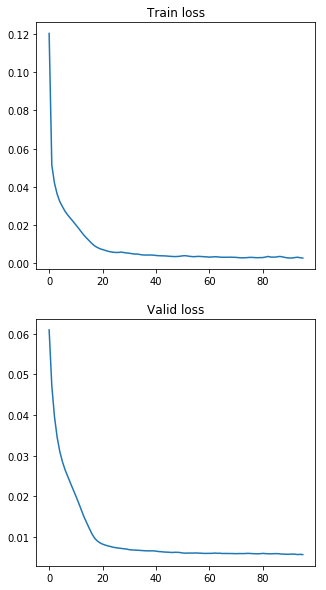

In [108]:
fig, axs = plt.subplots(2, 1, figsize=(5, 10))

ax = axs[0]
ax.plot(trainer.metrics['train']['losses'])
ax.set_title('Train loss')

ax = axs[1]
ax.plot(trainer.metrics['valid']['losses'])
ax.set_title('Valid loss')

## Avaliação


In [109]:
def to_cpu(T):
    if isinstance(T, (list, tuple)):
        return tuple(t.cpu() for t in T)
    elif isinstance(T, dict):
        return {k: t.cpu() for k, t in T.items()}
    return T.cpu()

def to_np(T):
    T = to_cpu(T)
    if isinstance(T, (list, tuple)):
        return tuple(t.numpy() for t in T)
    elif isinstance(T, dict):
        return {k: t.numpy() for k, t in T.items()}
    return T.numpy()

In [110]:
model = model.eval()

ds['eval'] =  MultiDigitDataset(datasets_mnist['val'],
                               length=12800,
                               transform=torchvision.transforms.ToTensor(),
                               random=True,
                               image_size=(200, 200))

dls['eval'] = data.DataLoader(ds['val'],
                              batch_size=128,
                              num_workers=os.cpu_count(),
                              shuffle=False,
                              collate_fn=collate_fn)


X, Y = get_batch(dls['eval'])

sample_no = 63
x = X[sample_no:sample_no+1, ...]
boxes, labels = Y['coords'][sample_no], Y['labels'][sample_no]

with torch.no_grad():
    y_pred = model(x.to(0))
y_pred = to_cpu(y_pred)

x = x.cpu()[0]

y_pred[0].shape, y_pred[1].shape

(torch.Size([1, 14, 20, 20]), torch.Size([1, 14, 10, 10]))

### Visualizando amostra de entrada

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


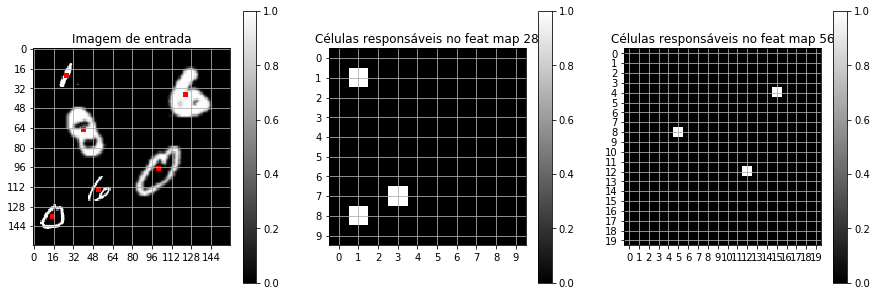

In [111]:
plot_sample((x.numpy()[0],
             [{'coords': box, 'label': lab} for (box, lab) in zip(boxes, labels)]),
            downsample=16)

### Visualizando resultado da predição

In [112]:
boxes, labels, confs = model.decode_bboxes(y_pred)
boxes, labels, confs

(array([[ 97.30558443,   9.59925652,  56.        ,  56.        ],
        [ 98.13839626,  17.73737097,  56.        ,  56.        ],
        [ 16.21205568,  40.46447229,  56.        ,  56.        ],
        [ 73.85379553,  73.60599518,  56.        ,  56.        ],
        [ 14.14757347,  13.29716492,  28.        ,  28.        ],
        [ 45.75085354, 108.34139824,  28.        ,  28.        ],
        [ 12.55267048, 125.74374008,  28.        ,  28.        ]]),
 array([6, 6, 8, 0, 1, 6, 0]),
 array([0.7541675 , 0.51427   , 0.6020989 , 0.67801255, 0.9963236 ,
        0.99407285, 0.82771873], dtype=float32))

In [152]:
def plot_output(x, boxes, ax=None):
    boxes, labels, confs = boxes
    
    H, W = x.shape[-2:]
    color_list = plt.cm.gist_rainbow(np.linspace(0, 1, 10))
    if ax is None:
        ax = plt.subplot(111)
    cax = ax.imshow(x, cmap='gray')
    
    for box, label, conf in zip(boxes, labels, confs):
        x, y, h, w = box
        color = color_list[label]
        patch = ax.add_patch(patches.Rectangle(box[:2], w, h, fill=False, edgecolor=color, lw=2))
        ax.text(x, y-2, str(label), color=color, size=20)
        ax.set_xticks(np.arange(0, W, 16))
        ax.set_yticks(np.arange(0, H, 16))
        ax.grid(True, linestyle=':')
    

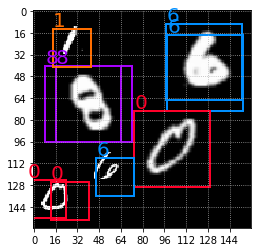

In [159]:
boxes = model.decode_bboxes(y_pred, conf_thresh=0.3)
plot_output(x.numpy()[0], boxes)

### Visualizando diversas imagens (com e sem NMS)

#### Non-Maximum Suppression

#### OBS: A implementação `non_max_suppression_fast` possuia um erro: as bboxes devem ser ordenadas pela maior probabilidade de presença de objeto, e não pela maior coordenada de y

In [223]:
# Funções de conversão de bounding boxes entre [x1, y1, h, w] e [x1, y1, x2, y2]
def hw2xy(boxes):
    out = np.zeros_like(boxes)
    out[:, :2] = boxes[:, :2]
    out[:, 2:] = boxes[:, :2] + boxes[:, 2:] + 1
    return out


def xy2hw(boxes):
    out = np.zeros_like(boxes)
    out[:, :2] = boxes[:, :2]
    out[:, 2:] = boxes[:, 2:] - boxes[:, :2] - 1
    return out


# Malisiewicz et al.
# Adaptado de: https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
def non_max_suppression_fast(boxes, confs, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes	
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the highest confidences
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(confs)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    # Return only the indices of the boxes that survived
    return np.asarray(pick)

### Visualizando

In [126]:
X, Y = get_batch(dls['eval'])
with torch.no_grad():
    ypred = model(X.cuda())
ypred = to_cpu(ypred)

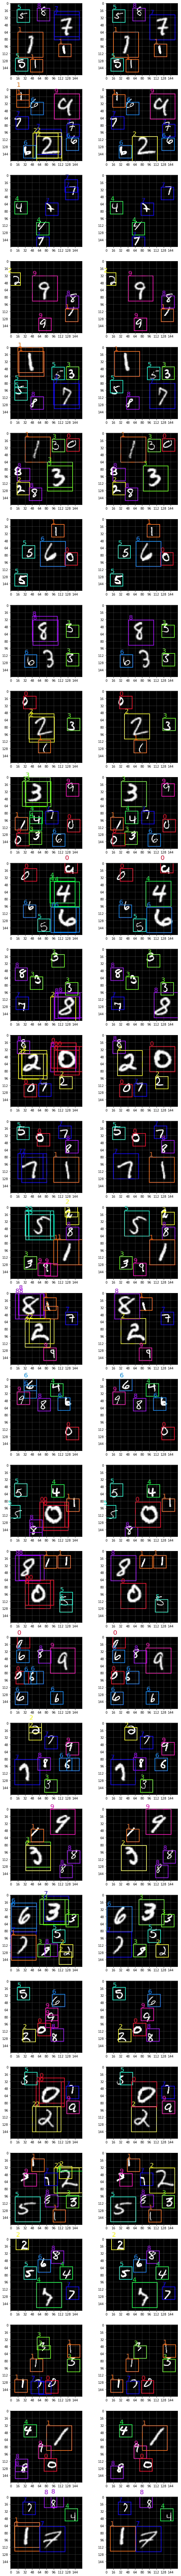

In [224]:
nrows = 30
ncols = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows))

for ix, row in enumerate(axs):
    
    boxes, labels, confs = model.decode_bboxes((ypred[0][ix], ypred[1][ix]), conf_thresh=0.2)
    # Plot without NMS
    ax = row[0]
    plot_output(X[ix].numpy().squeeze(), (boxes, labels, confs), ax=ax)
    
    # Plot after NMS
    idx = non_max_suppression_fast(hw2xy(boxes), confs, overlapThresh=0.1)
    boxes, labels, confs = boxes[idx], labels[idx], confs[idx]
    ax = row[1]
    plot_output(X[ix].numpy().squeeze(), (boxes, labels, confs), ax=ax)